In [1]:
# !pip install wheel
# !pip install h5py
# !pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
import h5py
import yaml
import pickle
import os
import argparse
import random
from tqdm.notebook import tqdm
from collections import Counter
from dataclasses import dataclass, field
import contextlib
import math
from heapq import merge
from math import floor
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import product
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from statsmodels.stats.multitest import multipletests
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

In [3]:
data = pd.read_csv('../processed_data/utrs.csv')
data = data[['Gene Name', 'foreign']].dropna(axis=0).rename(columns={'Gene Name': 'gene', 'foreign':'seq'})

In [4]:
data.head()

,gene,seq
4,VPS8,ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAAT...
5,SSA1,AGCCAATTGGTGCGGCAATTGATAATAACGAAAATGTCTTTTAATG...
6,ERP2,AGAACTTTTCAATCTACGAAAAATATATGTCCGCAATATAGAACAC...
7,FUN14,AGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCGTT...
8,SPO7,AAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTACC...


In [5]:
KMER_SIZE = 5

In [6]:
# Efficiency element
eff_el1 = "TATATA"
eff_el2 = "TTTTTATA"
eff_ctrl = "GCGCGC"
# Mutational scan of efficiency element?
# Positioning element
pos_el = "AAWAAA"
# Puf protein binding sites
puf1_2 = "TAATNNNTAAT"
puf3 = "TGTANATA"
puf4 = "TGTANANTA"
puf5 = "TGTANNNNTA"
puf6 = "TTGT"
# Poly-T sequences
poly_t = "TTTTTTTT"
_elems = [eff_el1, eff_el2, eff_ctrl,
           pos_el,
           puf1_2, puf3, puf4, puf5, puf6,
           poly_t]
specElements = []
# expand elements above by replacing Ns with A,T,G or C and Ws with A or T
for elem in _elems:
    specElements.extend([''.join(y) for y in list(product(*(['A', 'T', 'G', 'C'] if x=='N'  else (
        ['A', 'T'] if x=='W' else  (x,)) for x in elem)))])
# augment elements using all contiguous subsequences of size k - 1  of them, if the element size is larger than K
specElements = list(set(specElements + sum([[x[:-1], x[1:]] for x in specElements if len(x) > KMER_SIZE], [])))
    

In [7]:
len(specElements)

1037

### Compute Stride (overlap) of subsequence reading based on current subsequence entropy

In [8]:
def entropy(string):
    "Calculates the Shannon entropy of a string"

    # get probability of chars in string
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

    # calculate the entropy
    entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

    return min(1, abs(entropy) / 2)
def compute_stride(seq):
    return max(1, round(len(seq) * (1 - entropy(seq))))

We apply stride computation to the 20 first specific elements above

In [9]:
search_strides = [compute_stride(s) for s in specElements[:20]]
list(map(tuple, zip(*[specElements,search_strides])))

[('TAATTATTAA', 5),
 ('TTTTTAT', 5),
 ('TGTAGCAGTA', 1),
 ('GTAAGATTA', 2),
 ('GTAACCATA', 1),
 ('TGTAGCTCT', 1),
 ('GTAGCCGTA', 1),
 ('TGTAGTACT', 1),
 ('GTAGATTA', 2),
 ('TGTAAATATA', 3),
 ('TGTAAGTTT', 3),
 ('GTATTAATA', 3),
 ('GTAGATA', 2),
 ('TGTACGAATA', 1),
 ('TGTATTGATA', 3),
 ('GTATTAGTA', 2),
 ('GTATGCATA', 1),
 ('TAATTATTAAT', 6),
 ('TGTACAATA', 1),
 ('AATCCGTAAT', 1)]

In [10]:
def search_kmer_adaptive(seq, sub, stride):
    # Search positions of subsequence in seq, while respecting provided stride, in case of a hit
    found = []
    pos = 0
    while pos < len(seq):
        if seq[pos:pos+len(sub)] == sub:
            found.append(pos)
            pos += stride
        else:
            pos += 1
    return found

def get_kmers_adaptive(seq, k, min_stride):
    #Get K-Mers existing in the sequence seq, while computing the stride based on entropy and 
    #respecting a minimum stride
    kmers = []
    pos = 0
    while pos < len(seq):
        if pos + k > len(seq):
            break
        kmers.append(seq[pos:pos+k])
        pos += max(min_stride, compute_stride(kmers[-1]))
    return kmers

def search_all_kmers(seq, specElements, kmer_size, min_stride):
    # sort specific elements based on their length, so in case of overlap hit,
    # found sequences are ordered in a logical matter
    # eg AGT and AGTAC found both in position j, the produced string will be "AGT AGTAC"
    specElements = sorted(specElements, key=len)
    pairs = []
    # Retrieve the found positions of each element and merge all the found elements positions together
    for elem in specElements:
        pos = search_kmer_adaptive(seq, elem, compute_stride(elem))
        new_words_len = [len(elem) for _ in range(len(pos))]
        new_words = [elem for _ in range(len(pos))]
        new_pairs = list(map(tuple, zip(*[pos,new_words_len,new_words]))) 
        pairs = merge(pairs, new_pairs)
    pairs = [(x[0],x[0] + x[1], x[2]) for x in list(pairs)]
    # For the remaining intervals, in between found elements, get the kmers of the specific kmer_size
    # and with the minimum stride min_stride
    final_sequence = []
    # start of sequence (before findings)
    if not pairs:
        return get_kmers_adaptive(seq, kmer_size, min_stride)
    final_sequence =  get_kmers_adaptive(seq[:pairs[0][0] + compute_stride(pairs[0][2])], kmer_size, min_stride)
    # middle of sequence (with intertwined findings)
    for cnt in range(len(pairs) - 1):
        final_sequence.append(pairs[cnt][2])
        final_sequence.extend(
            get_kmers_adaptive(
                seq[pairs[cnt][1] - compute_stride(pairs[cnt][2]) :
                    pairs[cnt+1][0] + compute_stride(pairs[cnt + 1][2])], kmer_size, min_stride))
    # end of sequence (after findings)
    final_sequence.append(pairs[-1][2])
    final_sequence.extend(
        get_kmers_adaptive(seq[pairs[-1][1] - compute_stride(pairs[-1][2]):],
                           kmer_size, min_stride))
    return final_sequence

### An example of how the first 3'UTR sequence is split based on the algorithm above

In [11]:
data.seq.iloc[0]

'ACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAAATTTATACACCTCATTTCATTATGTAGATTCATATATAGAATACCAATTATGATTG'

In [12]:
search_all_kmers(data.seq.iloc[0], specElements, KMER_SIZE, KMER_SIZE//2)

['ACATT',
 'ATTTC',
 'TTCTA',
 'CTAAA',
 'AAATA',
 'AATATTTAAT',
 'TTAAT',
 'ATACA',
 'ACAAC',
 'ACTTT',
 'TTTGG',
 'GGTTA',
 'TTACA',
 'ACATA',
 'ATAAA',
 'AAAAG',
 'AGTAA',
 'TAAAA',
 'AATTT',
 'TTATA',
 'TACAC',
 'CACCT',
 'CCTCA',
 'TCATT',
 'ATTTC',
 'TTCAT',
 'CATTA',
 'TTATG',
 'TGTAGAT',
 'TGTAGATT',
 'TTCAT',
 'ATATA',
 'TATAT',
 'TATATA',
 'ATAGA',
 'AGAAT',
 'AATAC',
 'TACCA',
 'CCAAT',
 'AATTA',
 'TATGA',
 'TGATT']

In [13]:
from tqdm.notebook import tqdm
tqdm.pandas()

preprocessed_seq = data.seq.progress_apply(search_all_kmers, specElements=specElements, kmer_size=KMER_SIZE, min_stride=KMER_SIZE//2)
corpus = [y  for x in preprocessed_seq for y in x]

  0%|          | 0/4870 [00:00<?, ?it/s]

In [14]:
len(corpus)

574322

In [15]:
print("Maximum vocabulary size:", len(set(corpus)))

Maximum vocabulary size: 1973


In [16]:
%%writefile gloveConfig.yaml
# first step parameters
## size of the context window
window_size: 11
## maximum vocab_size
vocab_size: 10000
## the number of paritions to divide cooccurence matrix in 
num_partitions: 10
## chunk size of h5py.Dataset
chunk_size: 1000000

# when used in first step, specify the output directory of cooccurrence entries
# when used in second step, specify where to read cooccurrence entries from
cooccurrence_dir: ../processed_data/utrs/cooccurence

# second step parameters
## output path for the trained word vectors 
output_filepath: ../model/utrs/gloveModel
## pytorch training parameters
batch_size: 128
num_epochs: 100
device: cuda
learning_rate: 0.1
## glove paremeters
embedding_size: 100
x_max: 100
alpha: 0.75

Overwriting gloveConfig.yaml


In [17]:
def load_config():
    config_filepath = "gloveConfig.yaml"
    with open(config_filepath, 'r') as f:
        config_dict = yaml.load(f, Loader=yaml.FullLoader)
    config = argparse.Namespace()
    for key, value in config_dict.items():
        setattr(config, key, value)
    return config

In [18]:

@dataclass
class Vocabulary:
    token2index: dict = field(default_factory=dict)
    index2token: dict = field(default_factory=dict)
    token_counts: list = field(default_factory=list)
    _unk_token: int = field(init=False, default=-1)
    
    def add(self, token):
        if token not in self.token2index:
            index = len(self)
            self.token2index[token] = index
            self.index2token[index] = token
            self.token_counts.append(0)
        self.token_counts[self.token2index[token]] += 1
    
    def get_topk_subset(self, k):
        tokens = sorted(
            list(self.token2index.keys()),
            key=lambda token: self.token_counts[self[token]],
            reverse=True
        )
        return type(self)(
            token2index={token: index for index, token in enumerate(tokens[:k])},
            index2token={index: token for index, token in enumerate(tokens[:k])},
            token_counts=[
                self.token_counts[self.token2index[token]] for token in tokens[:k]
            ]
        )
    
    def shuffle(self):
        new_index = [_ for _ in range(len(self))]
        random.shuffle(new_index)
        new_token_counts = [None] * len(self)
        for token, index in zip(list(self.token2index.keys()), new_index):
            new_token_counts[index] = self.token_counts[self[token]]
            self.token2index[token] = index
            self.index2token[index] = token
        self.token_counts = new_token_counts

    def get_index(self, token):
        return self[token]
    
    def get_token(self, index):
        if not index in self.index2token:
            raise Exception("Invalid index.")
        return self.index2token[index]
    
    @property
    def unk_token(self):
        return self._unk_token
    
    def __getitem__(self, token):
        if token not in self.token2index:
            return self._unk_token
        return self.token2index[token]
    
    def __len__(self):
        return len(self.token2index)

In [19]:
@dataclass
class Vectorizer:
    vocab: Vocabulary

    @classmethod
    def from_corpus(cls, corpus, vocab_size):
        vocab = Vocabulary()
        for token in corpus:
            vocab.add(token)
        vocab_subset = vocab.get_topk_subset(vocab_size)
        vocab_subset.shuffle()
        return cls(vocab_subset)

    def vectorize(self, corpus):
        return [self.vocab[token] for token in corpus]

In [20]:
@dataclass
class CooccurrenceEntries:
    vectorized_corpus: list
    vectorizer: Vectorizer
    
    @classmethod
    def setup(cls, corpus, vectorizer):
        return cls(
            vectorized_corpus=vectorizer.vectorize(corpus),
            vectorizer=vectorizer
        )
    
    def validate_index(self, index, lower, upper):
        is_unk = index == self.vectorizer.vocab.unk_token
        if lower < 0:
            return not is_unk
        return not is_unk and index >= lower and index <= upper

    def build(
        self,
        window_size,
        num_partitions,
        chunk_size,
        output_directory="."
    ):
        partition_step = max(1, len(self.vectorizer.vocab) // num_partitions)
        split_points = [0]
        while split_points[-1] + partition_step <= len(self.vectorizer.vocab):
            split_points.append(split_points[-1] + partition_step)
        split_points[-1] = len(self.vectorizer.vocab)

        for partition_id in tqdm(range(len(split_points) - 1)):
            index_lower = split_points[partition_id]
            index_upper = split_points[partition_id + 1] - 1
            cooccurr_counts = Counter()
            for i in tqdm(range(len(self.vectorized_corpus))):
                if not self.validate_index(
                    self.vectorized_corpus[i],
                    index_lower,
                    index_upper
                ):
                    continue
                
                context_lower = max(i - window_size, 0)
                context_upper = min(i + window_size + 1, len(self.vectorized_corpus))
                for j in range(context_lower, context_upper):
                    if i == j or not self.validate_index(
                        self.vectorized_corpus[j],
                        -1,
                        -1
                    ):
                        continue
                    cooccurr_counts[(self.vectorized_corpus[i], self.vectorized_corpus[j])] += 1 / abs(i - j)

            cooccurr_dataset = np.zeros((len(cooccurr_counts), 3))
            for index, ((i, j), cooccurr_count) in enumerate(cooccurr_counts.items()):
                cooccurr_dataset[index] = (i, j, cooccurr_count)
            if partition_id == 0:
                os.makedirs(output_directory, exist_ok=True)
                path = os.path.join(
                        output_directory,
                        "cooccurrence.hdf5"
                    )
                if os.path.isfile(path):
                    os.remove(path)
                file = h5py.File(
                    path,
                    "w"
                )
                dataset = file.create_dataset(
                    "cooccurrence",
                    (len(cooccurr_counts), 3),
                    maxshape=(None, 3),
                    chunks=(chunk_size, 3)
                )
                prev_len = 0
            else:
                prev_len = dataset.len()
                dataset.resize(dataset.len() + len(cooccurr_counts), axis=0)
            dataset[prev_len: dataset.len()] = cooccurr_dataset
        
        file.close()
        with open(os.path.join(output_directory, "vocab.pkl"), "wb") as file:
            pickle.dump(self.vectorizer.vocab, file)

In [21]:
config = load_config()
vectorizer = Vectorizer.from_corpus(
    corpus=corpus,
    vocab_size=min(config.vocab_size, len(set(corpus)))
)
cooccurrence = CooccurrenceEntries.setup(
    corpus=corpus,
    vectorizer=vectorizer
)
cooccurrence.build(
    window_size=config.window_size,
    num_partitions=config.num_partitions,
    chunk_size=config.chunk_size,
    output_directory=config.cooccurrence_dir
) 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

  0%|          | 0/574322 [00:00<?, ?it/s]

In [22]:
@dataclass
class CooccurrenceDataset(torch.utils.data.Dataset):
    token_ids: torch.Tensor
    cooccurr_counts: torch.Tensor

    def __getitem__(self, index):
        return [self.token_ids[index], self.cooccurr_counts[index]]
    
    def __len__(self):
        return self.token_ids.size()[0]

    
@dataclass
class HDF5DataLoader:
    filepath: str
    dataset_name: str
    batch_size: int
    device: str
    dataset: h5py.Dataset = field(init=False)

    def iter_batches(self):
        chunks = list(self.dataset.iter_chunks())
        random.shuffle(chunks)
        for chunk in chunks:
            chunked_dataset = self.dataset[chunk]
            dataloader = torch.utils.data.DataLoader(
                dataset=CooccurrenceDataset(
                    token_ids=torch.from_numpy(chunked_dataset[:,:2]).long(),
                    cooccurr_counts=torch.from_numpy(chunked_dataset[:,
                        2]).float()
                ),
                batch_size=self.batch_size,
                shuffle=True,
                pin_memory=True
            )
            for batch in dataloader:
                batch = [_.to(self.device) for _ in batch]
                yield batch

    @contextlib.contextmanager
    def open(self):
        with h5py.File(self.filepath, "r") as file:
            self.dataset = file[self.dataset_name]
            yield

In [23]:
class GloVe(nn.Module):

    def __init__(self, vocab_size, embedding_size, x_max, alpha):
        super().__init__()
        self.weight = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.weight_tilde = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            sparse=True
        )
        self.bias = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.bias_tilde = nn.Parameter(
            torch.randn(
                vocab_size,
                dtype=torch.float,
            )
        )
        self.weighting_func = lambda x: (x / x_max).float_power(alpha).clamp(0, 1)
    
    def forward(self, i, j, x):
        loss = torch.mul(self.weight(i), self.weight_tilde(j)).sum(dim=1)
        loss = (loss + self.bias[i] + self.bias_tilde[j] - x.log()).square()
        loss = torch.mul(self.weighting_func(x), loss).mean()
        return loss

In [24]:
config = load_config()
dataloader = HDF5DataLoader(
    filepath=os.path.join(config.cooccurrence_dir, "cooccurrence.hdf5"),
    dataset_name="cooccurrence",
    batch_size=config.batch_size,
    device=config.device
)
model = GloVe(
    vocab_size=min(config.vocab_size, len(set(corpus))),
    embedding_size=config.embedding_size,
    x_max=config.x_max,
    alpha=config.alpha
)
model.to(config.device)
optimizer = torch.optim.Adagrad(
    model.parameters(),
    lr=config.learning_rate
)
losses = []


with dataloader.open():
    model.train()
    
    for epoch in tqdm(range(config.num_epochs)):
        epoch_loss = 0
        for batch in tqdm(dataloader.iter_batches()):
            loss = model(
                batch[0][:, 0],
                batch[0][:, 1],
                batch[1]
            )
            epoch_loss += loss.detach().item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        losses.append(epoch_loss)
        print(f"Epoch {epoch}: loss = {epoch_loss}")
        os.makedirs(os.sep.join(config.output_filepath.split(os.sep)[:-1]),exist_ok=True)
        torch.save(model.state_dict(), config.output_filepath)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 0: loss = 22296.649602010777


0it [00:00, ?it/s]

Epoch 1: loss = 7518.228482600226


0it [00:00, ?it/s]

Epoch 2: loss = 4636.466236331655


0it [00:00, ?it/s]

Epoch 3: loss = 3255.0167092498455


0it [00:00, ?it/s]

Epoch 4: loss = 2458.959327937109


0it [00:00, ?it/s]

Epoch 5: loss = 1952.0306234983545


0it [00:00, ?it/s]

Epoch 6: loss = 1606.8715800562356


0it [00:00, ?it/s]

Epoch 7: loss = 1360.958541590477


0it [00:00, ?it/s]

Epoch 8: loss = 1179.0351207177212


0it [00:00, ?it/s]

Epoch 9: loss = 1040.2054802720008


0it [00:00, ?it/s]

Epoch 10: loss = 931.8374964194841


0it [00:00, ?it/s]

Epoch 11: loss = 845.3228921489631


0it [00:00, ?it/s]

Epoch 12: loss = 775.0597259541194


0it [00:00, ?it/s]

Epoch 13: loss = 717.2017463871126


0it [00:00, ?it/s]

Epoch 14: loss = 668.6986825596649


0it [00:00, ?it/s]

Epoch 15: loss = 627.6520182794621


0it [00:00, ?it/s]

Epoch 16: loss = 592.4402620591165


0it [00:00, ?it/s]

Epoch 17: loss = 561.9394935054346


0it [00:00, ?it/s]

Epoch 18: loss = 535.3029081956612


0it [00:00, ?it/s]

Epoch 19: loss = 511.8129011851066


0it [00:00, ?it/s]

Epoch 20: loss = 490.95864767701806


0it [00:00, ?it/s]

Epoch 21: loss = 472.3905132980511


0it [00:00, ?it/s]

Epoch 22: loss = 455.54834110097556


0it [00:00, ?it/s]

Epoch 23: loss = 440.30253700563264


0it [00:00, ?it/s]

Epoch 24: loss = 426.4914364481905


0it [00:00, ?it/s]

Epoch 25: loss = 413.8097923068517


0it [00:00, ?it/s]

Epoch 26: loss = 402.1935353545598


0it [00:00, ?it/s]

Epoch 27: loss = 391.45953393072404


0it [00:00, ?it/s]

Epoch 28: loss = 381.4931121303103


0it [00:00, ?it/s]

Epoch 29: loss = 372.2418187651455


0it [00:00, ?it/s]

Epoch 30: loss = 363.6539893457855


0it [00:00, ?it/s]

Epoch 31: loss = 355.5753378097184


0it [00:00, ?it/s]

Epoch 32: loss = 348.02624625698434


0it [00:00, ?it/s]

Epoch 33: loss = 340.9477272212391


0it [00:00, ?it/s]

Epoch 34: loss = 334.24116275759064


0it [00:00, ?it/s]

Epoch 35: loss = 327.9404525335278


0it [00:00, ?it/s]

Epoch 36: loss = 321.98833102033


0it [00:00, ?it/s]

Epoch 37: loss = 316.3408453936504


0it [00:00, ?it/s]

Epoch 38: loss = 310.9969283550543


0it [00:00, ?it/s]

Epoch 39: loss = 305.8962377203854


0it [00:00, ?it/s]

Epoch 40: loss = 301.05845338773986


0it [00:00, ?it/s]

Epoch 41: loss = 296.46394111401486


0it [00:00, ?it/s]

Epoch 42: loss = 292.064208805598


0it [00:00, ?it/s]

Epoch 43: loss = 287.8437563440386


0it [00:00, ?it/s]

Epoch 44: loss = 283.82443771181534


0it [00:00, ?it/s]

Epoch 45: loss = 279.9801238219862


0it [00:00, ?it/s]

Epoch 46: loss = 276.2967294097272


0it [00:00, ?it/s]

Epoch 47: loss = 272.755844554089


0it [00:00, ?it/s]

Epoch 48: loss = 269.3729222862763


0it [00:00, ?it/s]

Epoch 49: loss = 266.1328720144513


0it [00:00, ?it/s]

Epoch 50: loss = 262.99292652006505


0it [00:00, ?it/s]

Epoch 51: loss = 259.96621441379676


0it [00:00, ?it/s]

Epoch 52: loss = 257.054399517972


0it [00:00, ?it/s]

Epoch 53: loss = 254.25196305833316


0it [00:00, ?it/s]

Epoch 54: loss = 251.55382834290995


0it [00:00, ?it/s]

Epoch 55: loss = 248.94148074361016


0it [00:00, ?it/s]

Epoch 56: loss = 246.43483186590564


0it [00:00, ?it/s]

Epoch 57: loss = 244.00476528726645


0it [00:00, ?it/s]

Epoch 58: loss = 241.648255088092


0it [00:00, ?it/s]

Epoch 59: loss = 239.35674392646789


0it [00:00, ?it/s]

Epoch 60: loss = 237.15528373303064


0it [00:00, ?it/s]

Epoch 61: loss = 235.02338145118276


0it [00:00, ?it/s]

Epoch 62: loss = 232.9622099930973


0it [00:00, ?it/s]

Epoch 63: loss = 230.9419544631415


0it [00:00, ?it/s]

Epoch 64: loss = 229.00260116342315


0it [00:00, ?it/s]

Epoch 65: loss = 227.10989128367632


0it [00:00, ?it/s]

Epoch 66: loss = 225.27845926442788


0it [00:00, ?it/s]

Epoch 67: loss = 223.48896015458655


0it [00:00, ?it/s]

Epoch 68: loss = 221.77503995046894


0it [00:00, ?it/s]

Epoch 69: loss = 220.07922771092626


0it [00:00, ?it/s]

Epoch 70: loss = 218.43132043289555


0it [00:00, ?it/s]

Epoch 71: loss = 216.8481325005367


0it [00:00, ?it/s]

Epoch 72: loss = 215.285759210962


0it [00:00, ?it/s]

Epoch 73: loss = 213.78206657366061


0it [00:00, ?it/s]

Epoch 74: loss = 212.2894330450552


0it [00:00, ?it/s]

Epoch 75: loss = 210.86344523582153


0it [00:00, ?it/s]

Epoch 76: loss = 209.4627112841206


0it [00:00, ?it/s]

Epoch 77: loss = 208.09339504664555


0it [00:00, ?it/s]

Epoch 78: loss = 206.76533825375884


0it [00:00, ?it/s]

Epoch 79: loss = 205.47026655259893


0it [00:00, ?it/s]

Epoch 80: loss = 204.18711760112114


0it [00:00, ?it/s]

Epoch 81: loss = 202.9468649609937


0it [00:00, ?it/s]

Epoch 82: loss = 201.7441823313744


0it [00:00, ?it/s]

Epoch 83: loss = 200.56142513328163


0it [00:00, ?it/s]

Epoch 84: loss = 199.38517121834875


0it [00:00, ?it/s]

Epoch 85: loss = 198.25650754634705


0it [00:00, ?it/s]

Epoch 86: loss = 197.1407876858979


0it [00:00, ?it/s]

Epoch 87: loss = 196.07109306880264


0it [00:00, ?it/s]

Epoch 88: loss = 194.99892389127027


0it [00:00, ?it/s]

Epoch 89: loss = 193.95483129545863


0it [00:00, ?it/s]

Epoch 90: loss = 192.9381393835459


0it [00:00, ?it/s]

Epoch 91: loss = 191.94187548007412


0it [00:00, ?it/s]

Epoch 92: loss = 190.96786539530936


0it [00:00, ?it/s]

Epoch 93: loss = 190.01264238993954


0it [00:00, ?it/s]

Epoch 94: loss = 189.0710046859465


0it [00:00, ?it/s]

Epoch 95: loss = 188.17258713318074


0it [00:00, ?it/s]

Epoch 96: loss = 187.25326574526287


0it [00:00, ?it/s]

Epoch 97: loss = 186.36041407475045


0it [00:00, ?it/s]

Epoch 98: loss = 185.49845162899595


0it [00:00, ?it/s]

Epoch 99: loss = 184.63941139985266


Text(0, 0.5, 'Training Loss')

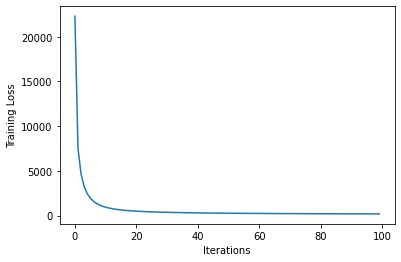

In [25]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel("Training Loss")

The subsequences embeddings are the trained weights of the model

In [26]:
vectors = (model.weight.weight.to('cpu').detach() + model.weight_tilde.weight.to('cpu').detach()).numpy()

In [27]:
kmers_vec = [vectorizer.vectorize(x) for x in preprocessed_seq]

The sequences embeddings are computed by the sum of the embeddings of their subsequences

In [28]:
data['kmers_enc'] = [np.sum(vectors[[y for y in x if y!=-1], :], axis=0) for x in kmers_vec]

In [29]:
import pickle
with open('../processed_data/utrs_glove_embeddings.pkl', 'wb') as out:
    pickle.dump({'data':np.vstack(data['kmers_enc']),'gene':data['gene']}, out)